In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random 
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
import pandas as pd 
import yaml 
import matplotlib.pyplot as plt; plt.ion()
from matplotlib import rc, rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from lenspack.utils import bin2d
from lenspack.image.inversion import ks93
from lenspack.peaks import find_peaks2d

from SMPy import utils
from SMPy.KaiserSquires import kaiser_squires, plot_kmap

In [2]:
def read_config(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

config = read_config("./config_truth_ra_dec.yaml")
#center_cl = {"ra_c": 104.629583, "dec_c": -55.946944}

In [3]:
def load_shear_data(shear_cat_path, ra_col, dec_col, g1_col, g2_col, mu_col, x_col, y_col, obj_class_col):
    """ 
    Load shear data from a FITS file and return a pandas DataFrame.

    :param path: Path to the FITS file.
    :param ra_col: Column name for right ascension.
    :param dec_col: Column name for declination.
    :param g1_col: Column name for the first shear component.
    :param g2_col: Column name for the second shear component.
    :param weight_col: Column name for the weight.
    :return: pandas DataFrame with the specified columns.
    """
    # Read data from the FITS file
    shear_catalog = Table.read(shear_cat_path)

    # Convert to pandas DataFrame
    shear_df = pd.DataFrame({
        'ra': shear_catalog[ra_col],
        'dec': shear_catalog[dec_col],
        'g1': shear_catalog[g1_col],
        'g2': shear_catalog[g2_col],
        'mu': shear_catalog[mu_col],
        'x': shear_catalog[x_col],
        'y': shear_catalog[y_col],
        'obj_class': shear_catalog[obj_class_col]
    })
    gal_idx = np.where(shear_df['obj_class'] == b'gal')[0]
    
    shear_df_c = []

    for i in gal_idx:
        shear_df_c.append(shear_df.iloc[i])
        
    shear_df_c = pd.DataFrame(shear_df_c)
    
    return shear_df_c

In [4]:
# Finally, computing the oringinal kappa map
shear_df = load_shear_data(config['input_path'], 
                                          config['ra_col'], 
                                          config['dec_col'], 
                                          config['g1_col'], 
                                          config['g2_col'], 
                                          config['mu_col'],
                                          config['x_col'],
                                          config['y_col'],
                                          config['obj_class_col'])

In [5]:
shear_df = utils.correct_RA_dec(shear_df)

In [6]:
boundaries = utils.calculate_field_boundaries_v2(shear_df['ra'], shear_df['dec'])
boundaries_xy = utils.calculate_field_boundaries_v2(shear_df['x'], shear_df['y'])

Text(0.5, 1.0, 'y vs dec')

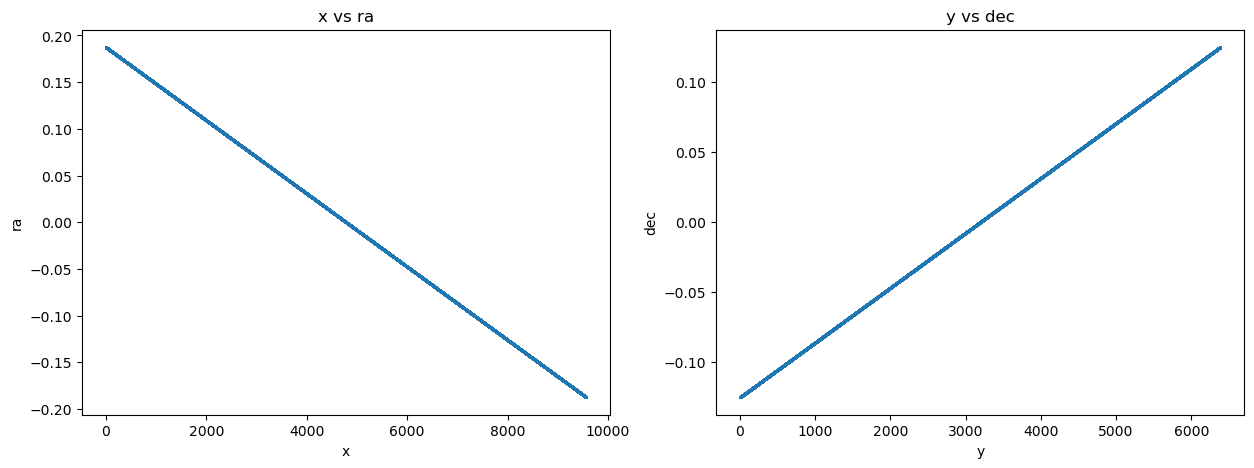

In [7]:
# Plot x vs ra and y_vs_dec
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(shear_df['x'], shear_df['ra'], s=1)
plt.xlabel('x')
plt.ylabel('ra')
plt.title('x vs ra')
plt.subplot(1, 2, 2)
plt.scatter(shear_df['y'], shear_df['dec'], s=1)
plt.xlabel('y')
plt.ylabel('dec')
plt.title('y vs dec')

In [8]:
aspect_ratio = (boundaries['ra_max'] - boundaries['ra_min']) / (boundaries['dec_max'] - boundaries['dec_min'])
pix_ra = 100
pix_dec = int(pix_ra / aspect_ratio)

g1map_og_1, g2map_og_1 = bin2d(shear_df['ra'], shear_df['dec'], v=(shear_df['g1'], shear_df['g2']), npix=[pix_ra, pix_dec])

og_kappa_e_1, og_kappa_b_1 = kaiser_squires.ks_inversion(g1map_og_1, g2map_og_1)

g1map_og_2, g2map_og_2 = bin2d(shear_df['x'], shear_df['y'], v=(shear_df['g1'], shear_df['g2']), npix=[pix_ra, pix_dec])

og_kappa_e_2, og_kappa_b_2 = kaiser_squires.ks_inversion(g1map_og_2, g2map_og_2)


## KS inversion Convergence from RA-Dec image and X-Y image 

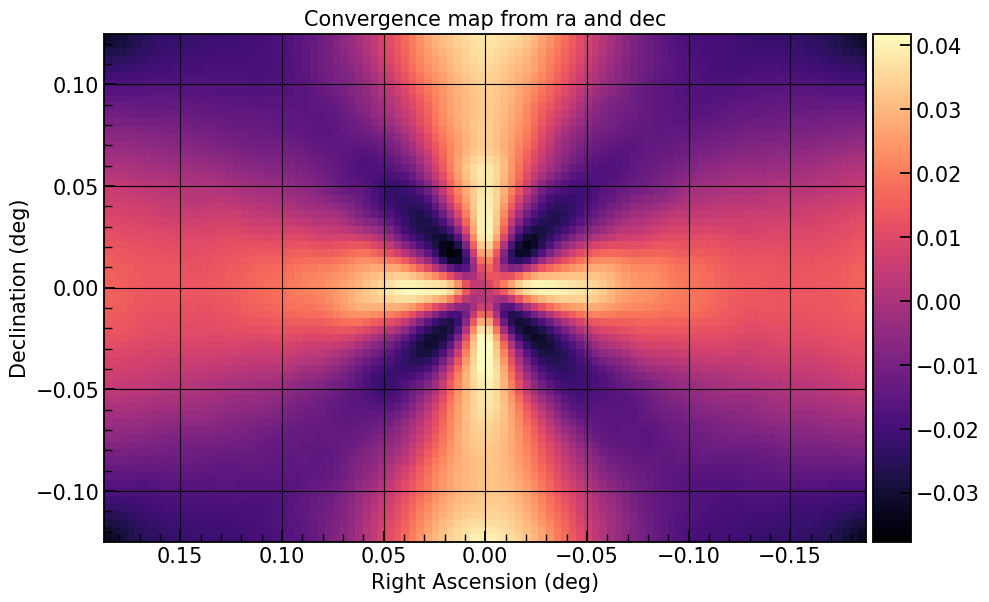

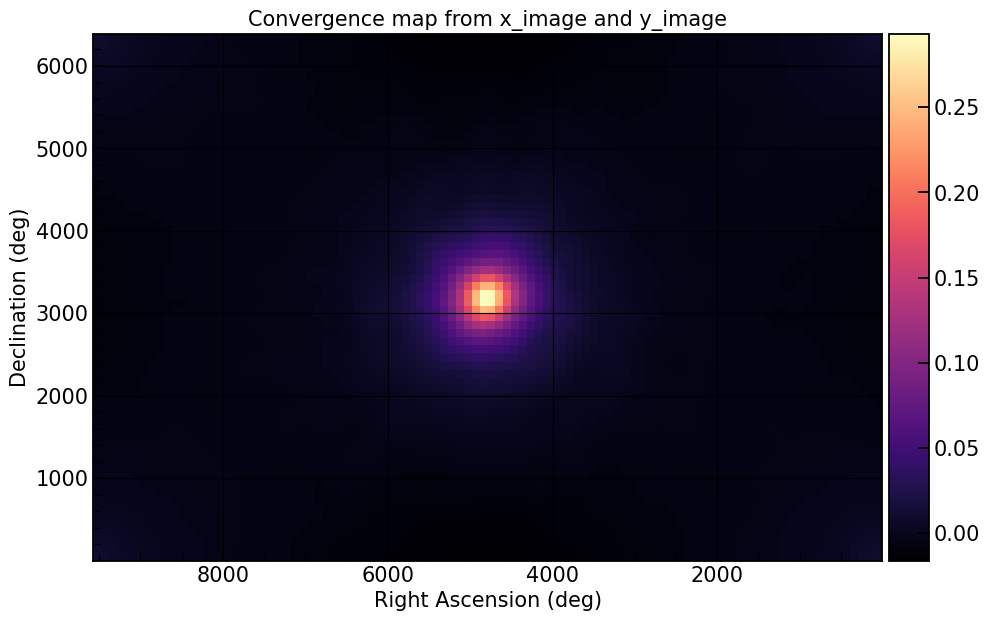

In [9]:
plot_kmap.plot_convergence_v3(og_kappa_e_1, boundaries, config, smoothing=1.5, title="Convergence map from ra and dec")
plot_kmap.plot_convergence_v3(og_kappa_e_2, boundaries_xy, config, smoothing=1.5, title="Convergence map from x_image and y_image")

## Now let's look at g1 and g2 maps
g1: Distortion along the real axes (x/y)
g2: Distortion along axes rotated through π/4 radians.

$g_1 := 2 \left( \psi_{,11} - \psi_{,22} \right), \\g_2 := 2 \left( \psi_{,12} + \psi_{,21} \right) = \psi_{,12}.$

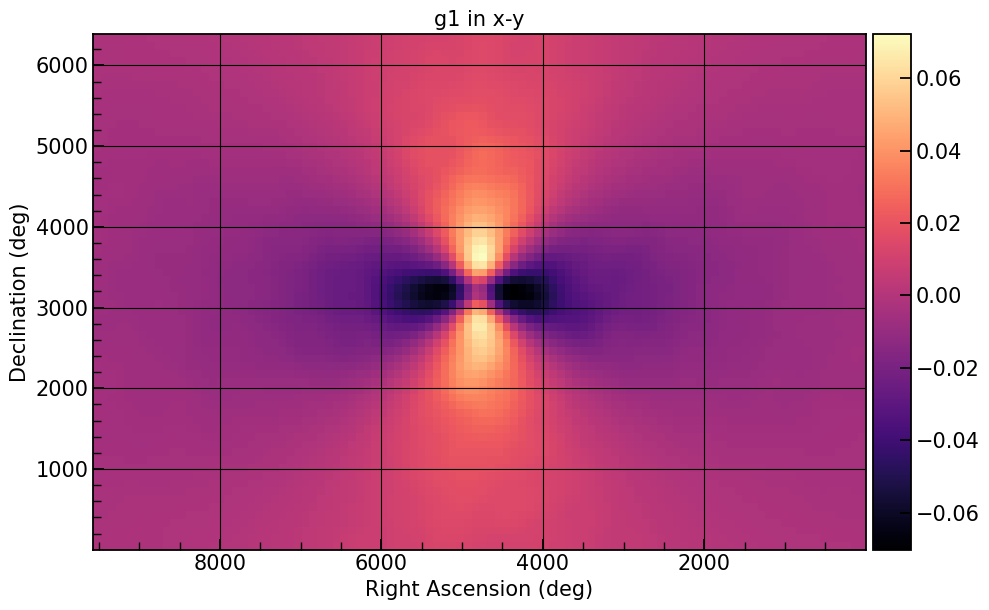

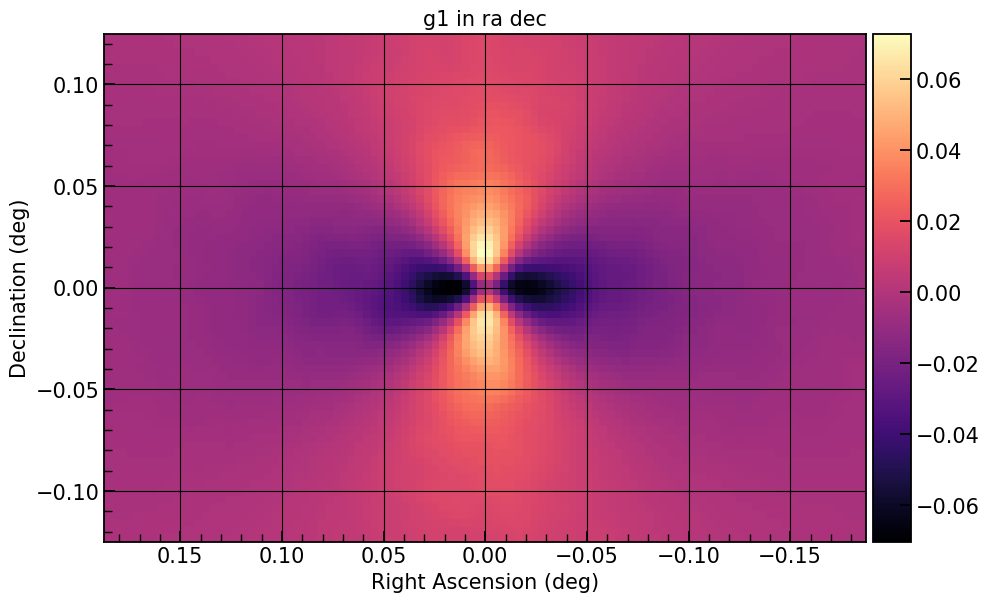

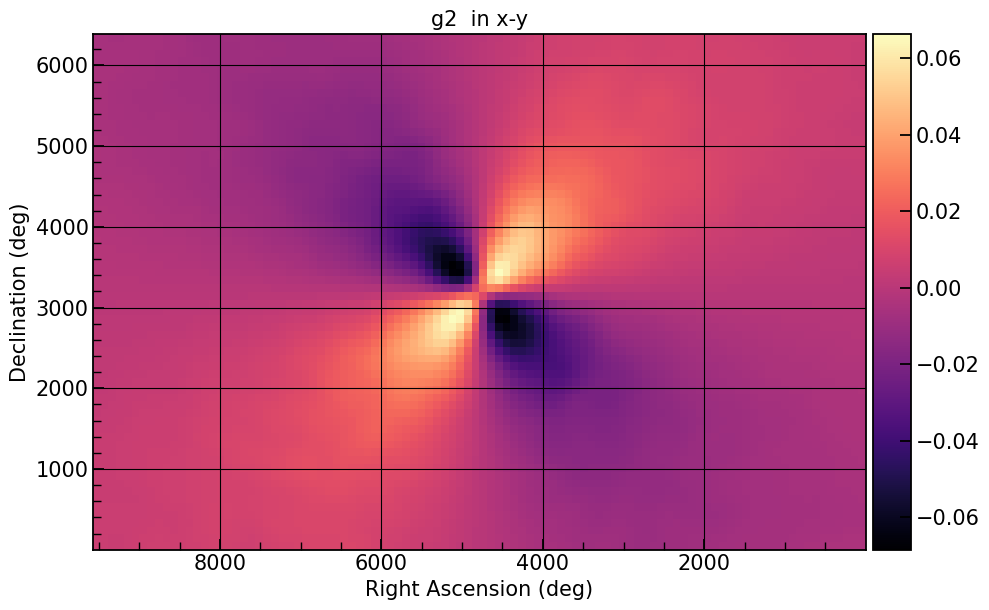

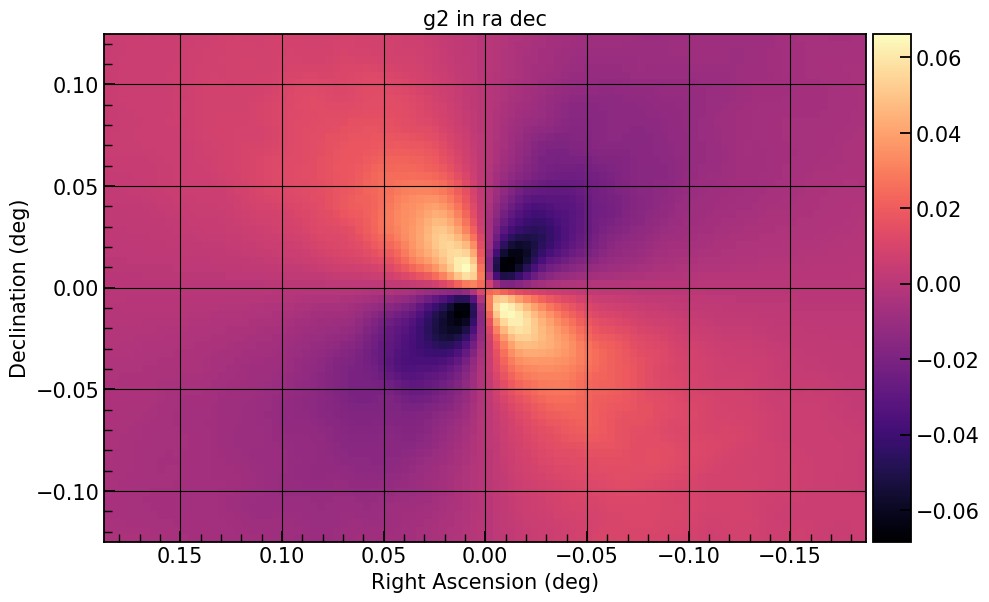

In [10]:
plot_kmap.plot_convergence_v3(g1map_og_2, boundaries_xy, config, smoothing=1.5, title="g1 in x-y")
plot_kmap.plot_convergence_v3(g1map_og_1, boundaries, config, smoothing=1.5, title="g1 in ra dec")
plot_kmap.plot_convergence_v3(g2map_og_2, boundaries_xy, config, smoothing=1.5, title="g2  in x-y")
plot_kmap.plot_convergence_v3(g2map_og_1, boundaries, config, smoothing=1.5, title="g2 in ra dec")

## Tangential and Cross shear (Eq. 10, 11 in McCleary et al. 2023)
$ g_{\text{tan}} = -\left(g_1 \cos(2\phi) + g_2 \sin(2\phi)\right)\\
g_{\times} = g_2 \cos(2\phi) - g_1 \sin(2\phi)
 $

In [13]:
center_cl = {"ra_c": (boundaries["ra_max"] + boundaries["ra_min"])/2, "dec_c": (boundaries["dec_max"] + boundaries["dec_min"])/2, "x_c": (boundaries_xy["ra_max"] + boundaries_xy["ra_min"])/2, "y_c": (boundaries_xy["dec_max"] + boundaries_xy["dec_min"])/2}
gt_og_1, gc_og_1, phi_1 = utils.g1g2_to_gt_gc(g1map_og_1, g2map_og_1, shear_df['ra'], shear_df['dec'], center_cl['ra_c'], center_cl['dec_c'])

gt_og_2, gc_og_2, phi_2 = utils.g1g2_to_gt_gc(g1map_og_2, g2map_og_2, shear_df['x'], shear_df['y'], center_cl['x_c'], center_cl['y_c'])

In [172]:
#plot_kmap.plot_convergence_v3(phi_1, boundaries, config, title="Phi in RA and DEC")
#plot_kmap.plot_convergence_v3(phi_2, boundaries_xy, config, title="Phi in x_image and y_image")

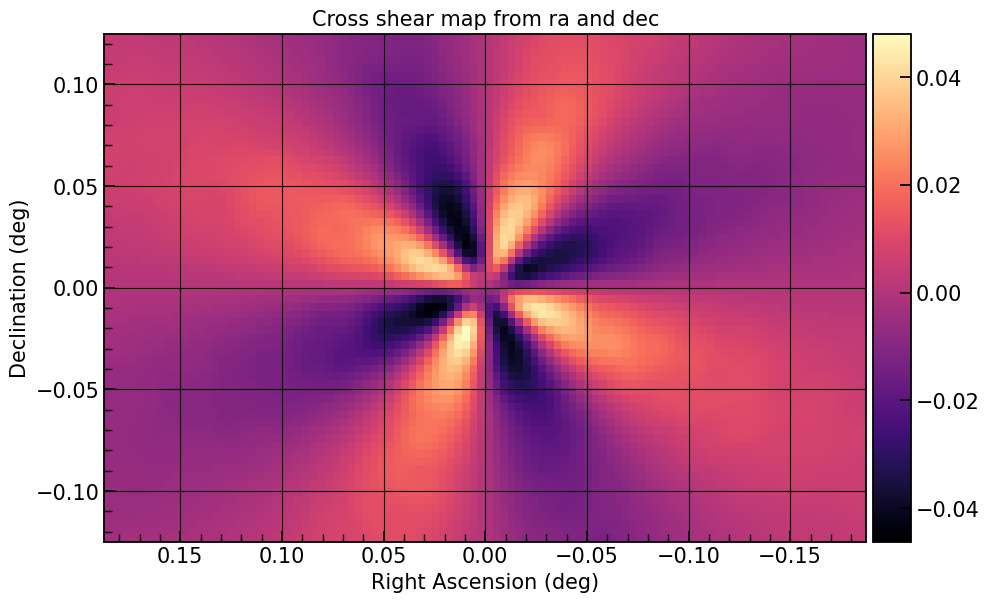

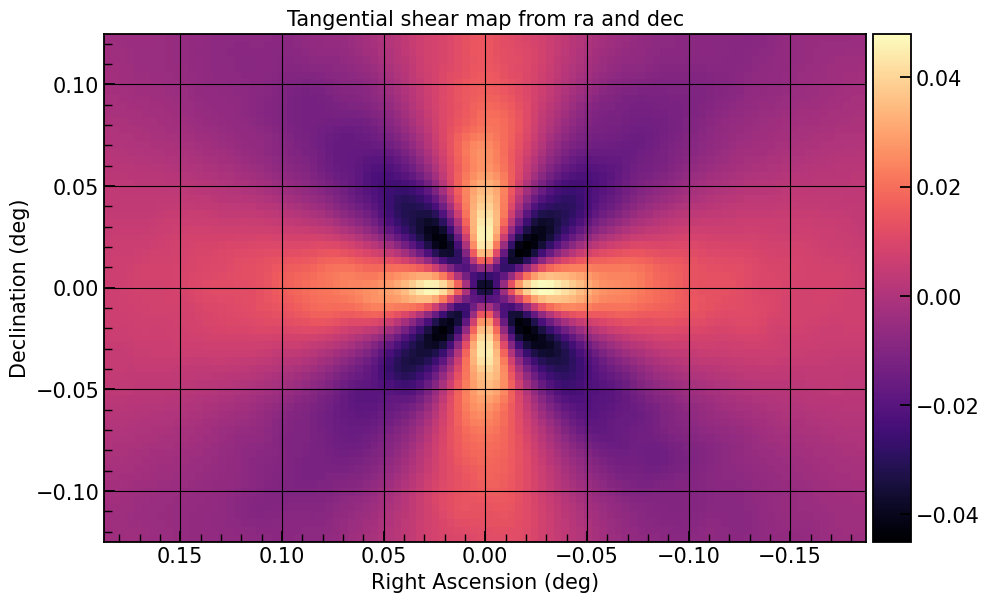

In [14]:
plot_kmap.plot_convergence_v3(gc_og_1, boundaries, config, smoothing=1.5, title="Cross shear map from ra and dec")
plot_kmap.plot_convergence_v3(gt_og_1, boundaries, config, smoothing=1.5, title="Tangential shear map from ra and dec")

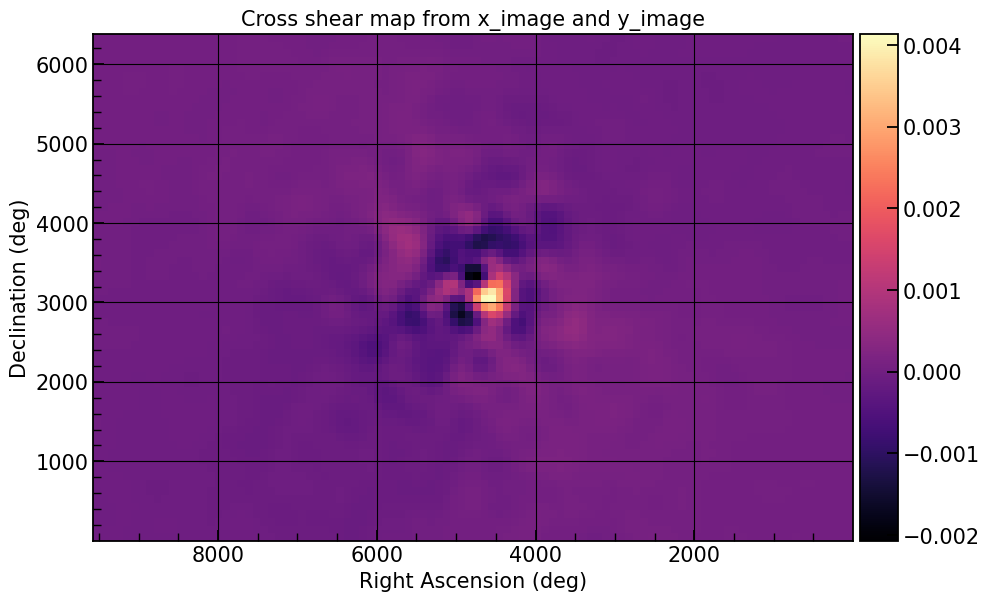

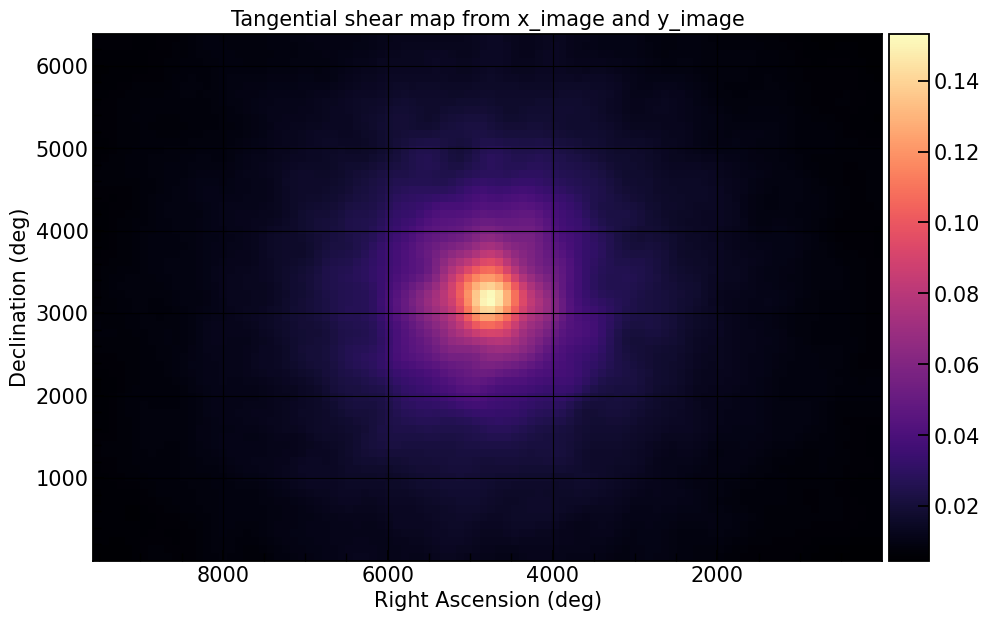

In [15]:
plot_kmap.plot_convergence_v3(gc_og_2, boundaries_xy, config, smoothing=1.5, title="Cross shear map from x_image and y_image")
plot_kmap.plot_convergence_v3(gt_og_2, boundaries_xy, config, smoothing=1.5, title="Tangential shear map from x_image and y_image")